In [118]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

# 'nearest' | 'linear' | 'bilinear' | 'bicubic' | 'trilinear' | 'area' | 'nearest-exact'

class ResBlk(nn.Module):
    def __init__(self, dim_in, dim_out, upsample=False, downsample=False, normalize=False):
        super().__init__()
        self.actv = nn.LeakyReLU(0.2)
        self.upsample = upsample
        self.downsample = downsample
        self.learned_sc = dim_in != dim_out
        self.normalize = normalize

        self.conv1 = nn.Conv2d(dim_in, dim_out, 3, 1, 1)
        self.conv2 = nn.Conv2d(dim_out, dim_out, 3, 1, 1)
        if self.learned_sc:
            self.conv1x1 = nn.Conv2d(dim_in, dim_out, 1, 1, 0, bias=False)
        if self.normalize:
            self.norm1 = nn.InstanceNorm2d(dim_in, affine=True)
            self.norm2 = nn.InstanceNorm2d(dim_out, affine=True)
            
    def _shortcut(self, x):
        if self.upsample:
            x = F.interpolate(x, scale_factor=2, mode='nearest-exact')
        if self.downsample:
            x = F.avg_pool2d(x, 2)
        if self.learned_sc:
            x = self.conv1x1(x)
        return x

    def _residual(self, x):
        if self.normalize:
            x = self.norm1(x)
        x = self.actv(x)
        if self.upsample:
            x = F.interpolate(x, scale_factor=2, mode='nearest-exact')
        if self.downsample:
            x = F.avg_pool2d(x, 2)
        x = self.conv1(x)
        if self.normalize:
            x = self.norm2(x)
        x = self.actv(x)
        x = self.conv2(x)
        return x

    def forward(self, x):
        out = self._residual(x)
        out = (out + self._shortcut(x)) / math.sqrt(2)
        return out
    

class PandaGenerator(nn.Module):
    
    def __init__(self, opt):
        
        super(PandaGenerator, self).__init__()
        
        self.latent_dim = opt['latent_dim']
        self.img_size = opt['img_size']
        self.num_channels = opt['channels']
        self.num_features = self.img_size // 64  # size of the intermediate feature maps = 256 // 64 = 4

        self.fc = nn.Linear(self.latent_dim, self.num_features * self.num_features * 512)
        self.res_blocks = nn.Sequential(
            # ResBlk(512, 512, upsample=False, normalize=True),
            # ResBlk(512, 512, upsample=False, normalize=True),
            ResBlk(512, 256, upsample=False, normalize=True),
            ResBlk(256, 128, upsample=True, normalize=True),
            ResBlk(128, 64, upsample=True, normalize=True),
            ResBlk(64, 32, upsample=True, normalize=True),
            ResBlk(32, 16, upsample=True, normalize=True),
            ResBlk(16, 8, upsample=True, normalize=True),
            ResBlk(8, self.num_channels, upsample=True, normalize=True)
        )
        self.final_conv = nn.Conv2d(self.num_channels, self.num_channels, 3, 1, 1)

    def forward(self, z):
        x = self.fc(z)
        x = x.view(-1, 512, self.num_features, self.num_features)
        x = self.res_blocks(x)
        x = self.final_conv(x)
        x = torch.tanh(x)
        return x
    
class PandaDiscriminator(nn.Module):
    
    def __init__(self, opt):
        
        super(PandaDiscriminator, self).__init__()
        
        self.latent_dim = opt['latent_dim']
        self.img_size = opt['img_size']
        self.num_channels = opt['channels']

        self.res_blocks = nn.Sequential(
            ResBlk(self.num_channels, 8, downsample=True, normalize=True),
            ResBlk(8, 16, downsample=True, normalize=True),
            ResBlk(16, 32, downsample=True, normalize=True),
            ResBlk(32, 64, downsample=True, normalize=True),
            ResBlk(64, 128, downsample=True, normalize=True),
            ResBlk(128, 256, downsample=True, normalize=True),
            ResBlk(256, 512, downsample=False, normalize=True),
            # ResBlk(512, 512, downsample=False, normalize=True),
            # ResBlk(512, 512, downsample=False, normalize=True)
        )
        self.fc = nn.Linear(512 * (self.img_size // 64) * (self.img_size // 64), 1)
        

    def forward(self, x):
        x = self.res_blocks(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        # x = torch.sigmoid(x)
        return x
    
    def forward_features(self, x):
        x = self.res_blocks(x)
        x = x.view(x.shape[0], -1)
        return x

class PandaEncoder(nn.Module):
    
    def __init__(self, opt):
        
        super(PandaEncoder, self).__init__()
        
        self.latent_dim = opt['latent_dim']
        self.img_size = opt['img_size']
        self.num_channels = opt['channels']

        self.res_blocks = nn.Sequential(
            ResBlk(self.num_channels, 8, downsample=True, normalize=True),
            ResBlk(8, 16, downsample=True, normalize=True),
            ResBlk(16, 32, downsample=True, normalize=True),
            ResBlk(32, 64, downsample=True, normalize=True),
            ResBlk(64, 128, downsample=True, normalize=True),
            ResBlk(128, 256, downsample=True, normalize=True),
            ResBlk(256, 512, downsample=False, normalize=True)
        )
        self.adv_layer = nn.Sequential(
            nn.Linear(512 * (self.img_size // 64) * (self.img_size // 64), self.latent_dim),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.res_blocks(x)
        x = x.view(x.size(0), -1)
        validity = self.adv_layer(x)
        return validity

In [119]:
import torch
import numpy as np

from torchvision import transforms
from torch.utils.data import DataLoader

from tqdm.auto import tqdm
import matplotlib.pyplot as plt

from dataset import ArchDataset, GS_NEGATIVE_PATHS, GS_POSITIVE_PATHS, GS_NEGATIVE_COORDS, GS_POSITIVE_COORDS
from train_wgan_spectral import train_wgan_spectral

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

params = {
    'batch_size': 256,
    'channels': 3,
    'img_size': 256,
    'latent_dim': 512,
    'lr': 0.0001,
    'b1': 0.5,
    'b2': 0.999,
    'weight_decay': 0,
    'n_epochs': 200,
    'n_critic': 5,
    'sample_interval': 100,
}


transform_crop_256 = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

train_dataset = ArchDataset(
    img_paths=GS_NEGATIVE_PATHS, 
    coords=GS_NEGATIVE_COORDS, 
    anomalies=False, 
    transform=transform_crop_256
)
train_loader = DataLoader(train_dataset, batch_size=params['batch_size'], shuffle=True)

anomalies_dataset = ArchDataset(
    img_paths=GS_POSITIVE_PATHS, 
    coords=GS_POSITIVE_COORDS, 
    anomalies=False, 
    transform=transform_crop_256
)
anomalies_loader = DataLoader(anomalies_dataset, batch_size=params['batch_size'], shuffle=False)

generator_path = f'/home/jupyter/datasphere/archaeology-project/fanogan_training/train_generator_discriminator/eduard_check/results_panda256_gs_v1_1/generator_190.pth'
generator = PandaGenerator(params)
generator.load_state_dict(torch.load(generator_path, map_location=torch.device('cpu')))

<All keys matched successfully>

In [120]:
# z = torch.randn(1, params['latent_dim'], device=device)[0]

In [121]:
with torch.no_grad():
    fake_imgs = generator(z)

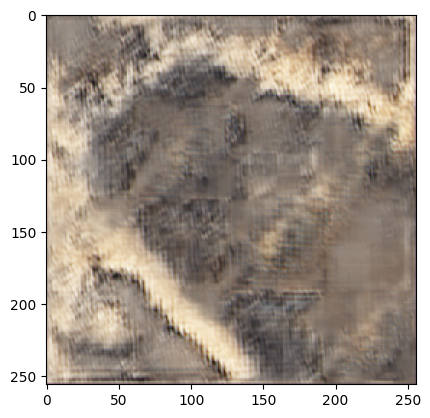

In [99]:
#area

import matplotlib.pyplot as plt

img = fake_imgs[0].permute(1, 2, 0)

img = (img - img.min()) / (img.max() - img.min())

plt.imshow(img)

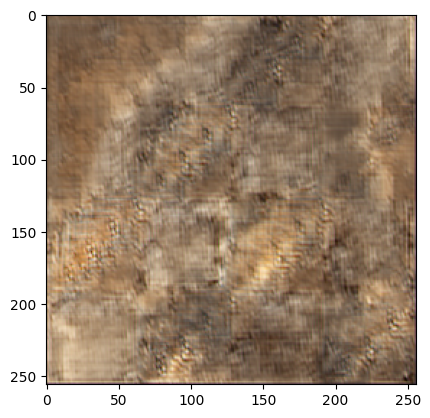

In [67]:
#trilinear

import matplotlib.pyplot as plt

img = fake_imgs[0].permute(1, 2, 0)

img = (img - img.min()) / (img.max() - img.min())

plt.imshow(img)

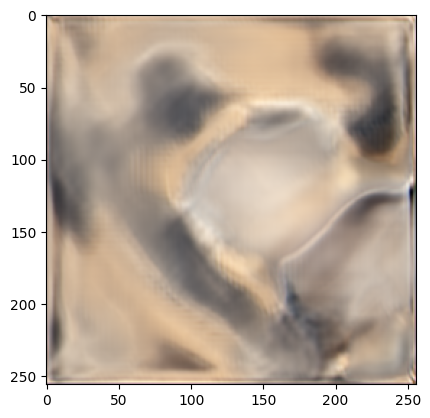

In [113]:
#bicubic

import matplotlib.pyplot as plt

img = fake_imgs[0].permute(1, 2, 0)

img = (img - img.min()) / (img.max() - img.min())

plt.imshow(img)

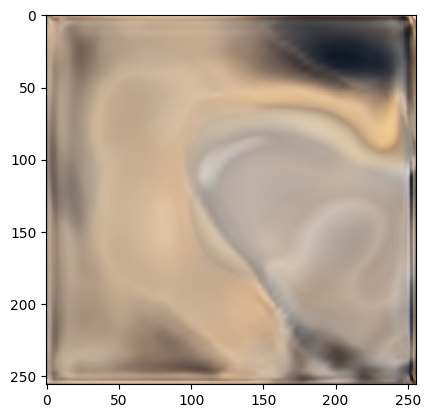

In [108]:
#bilinear

import matplotlib.pyplot as plt

img = fake_imgs[0].permute(1, 2, 0)

img = (img - img.min()) / (img.max() - img.min())

plt.imshow(img)

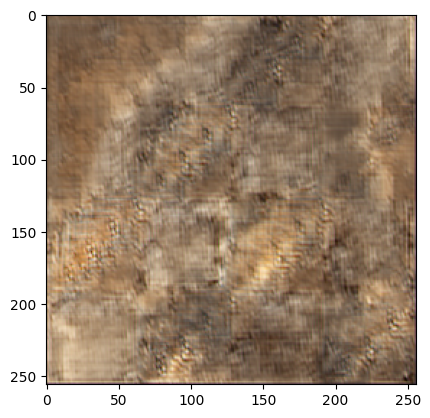

In [52]:
#linear

import matplotlib.pyplot as plt

img = fake_imgs[0].permute(1, 2, 0)

img = (img - img.min()) / (img.max() - img.min())

plt.imshow(img)

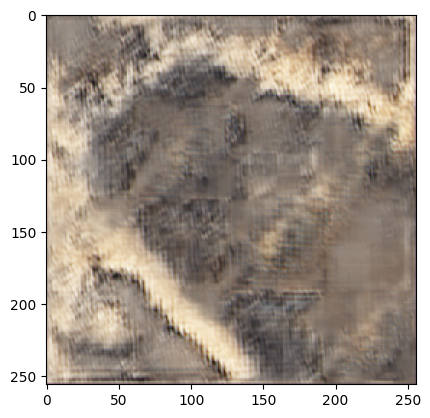

In [122]:
#nearest-exact

import matplotlib.pyplot as plt

img = fake_imgs[0].permute(1, 2, 0)

img = (img - img.min()) / (img.max() - img.min())

plt.imshow(img)